In [ ]:
import os
import tensorflow as tf
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

tfk = tf.keras
tfkl = tf.keras.layers

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
#loading dataset
%cd ../input/an2dl-dataset-hw2

/kaggle/input/an2dl-dataset-hw2


In [ ]:
%ls

x_train.npy  y_train.npy


# **Data Preprocessing**

In [ ]:
x = np.load("./x_train.npy")
y = np.load("./y_train.npy")

y_categorical = tfk.utils.to_categorical(y)

{'Wish': 0, 'Another': 1, 'Comfortably': 2, 'Money': 3, 'Breathe': 4, 'Time': 5, 'Brain': 6, 'Echoes': 7, 'Wearing': 8, 'Sorrow': 9, 'Hey': 10, 'Shine': 11}
12


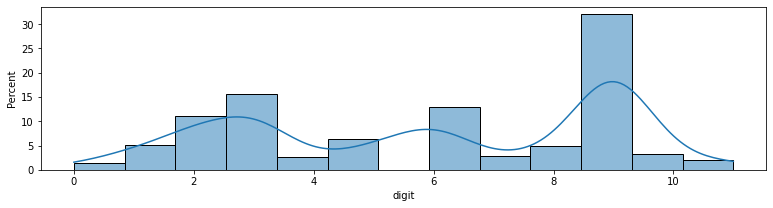

Counting occurrences of target classes:
9     777
3     381
6     313
2     270
5     153
1     123
8     120
10     77
7      68
4      62
11     51
0      34
Name: digit, dtype: int64


In [ ]:
classes = [
    "Wish",
    "Another",
    "Comfortably",
    "Money",
    "Breathe",
    "Time",
    "Brain",
    "Echoes",
    "Wearing",
    "Sorrow",
    "Hey",
    "Shine"]

#target
target_dict = {classes[k]: v for v, k in enumerate(np.unique(y))}
print(target_dict)

# Convert the label to categorical
target_val = [target_dict[classes[i]] for i in range(len(classes))]
y2 = tfk.utils.to_categorical(target_val)
print(len(target_val))

# Inspect the target
plt.figure(figsize=(13,3))
sns.histplot(data=pd.DataFrame(y, columns=['digit']), x='digit', stat="percent", element="bars", fill=True, kde=True)
plt.show()

print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())


train size:  (1943, 36, 6) (1943,) 
test size:  (486, 36, 6) (486,)
[ 27.  98. 216. 305.  50. 122. 250.  54.  96. 622.  62.  41.]


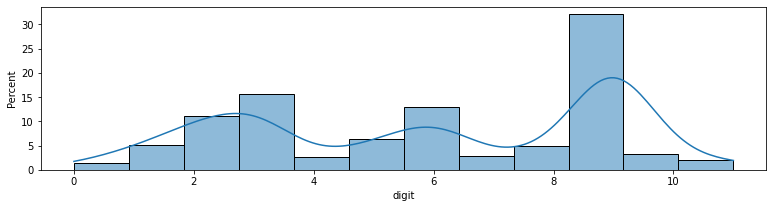

[  7.  25.  54.  76.  12.  31.  63.  14.  24. 155.  15.  10.]
in the test there are  12  classes


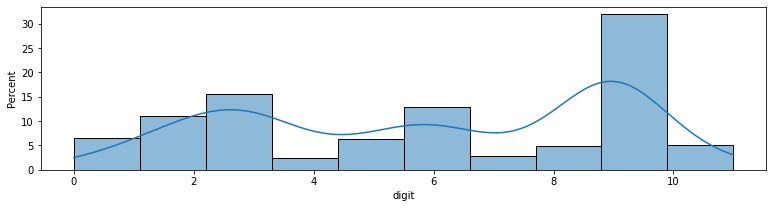

In [ ]:
#SPLIT TRAIN AND VALIDATION

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=seed, test_size=.2, stratify = y)
print('train size: ',  x_train.shape, y_train.shape, '\ntest size: ', x_test.shape, y_test.shape)

#verify how many elements for each class there are in y_train
count_train = np.zeros(y_categorical.shape[-1])
for i in range(len(count_train)):
    count_train[i] = list(y_train).count(i)
    i+=1
print(count_train)

plt.figure(figsize=(13,3))
sns.histplot(data=pd.DataFrame(y_train, columns=['digit']), x='digit', stat="percent", element="bars", fill=True, kde=True)
plt.show()

#verify how many elements for each class there are in y_test
count_test = np.zeros(y_categorical.shape[-1])
for i in range(len(count_test)):
    count_test[i] = list(y_test).count(i)
    if(list(y_test).count(i) == 0): count_test[i]=0
    i+=1
print(count_test)
print('in the test there are ', len(count_test), ' classes')

plt.figure(figsize=(13,3))
sns.histplot(data=pd.DataFrame(y_test, columns=['digit']), x='digit', stat="percent", element="bars", fill=True, kde=True)
plt.show()

In [ ]:
#metadata for model and fit

y_classes = tfk.utils.to_categorical(y_train)

input_shape = x_train.shape[1:]
classes = y_classes.shape[-1]

batch_size = 8
epochs = 300

print(y_classes.shape)

(1943, 12)


In [ ]:
def plot_confusion_matrix(model, x_test):
    # Predict the test set
    predictions = model.predict(x_test)
    y_test_cat = tfk.utils.to_categorical(y_test)

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test_cat, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_test_cat, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_test_cat, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_test_cat, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_test_cat, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    print('Accuracy:',accuracy.round(4))
    print('Precision:',precision.round(4))
    print('Recall:',recall.round(4))
    print('F1:',f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, xticklabels=classes, yticklabels=classes)
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

# **Best Model**

**Attention Layer**

In [ ]:
import tensorflow.keras.backend as K

class attention(tfkl.Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

**Hybrid model**

In [ ]:
def build_hybrid_model(input_shape, classes):

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    norm = tfkl.Normalization(axis=-1, mean=0, variance=10)(input_layer)

    # model with conv dimension 3
    cnn = tfkl.Conv1D(256,3,padding= 'same',activation='relu')(norm)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(2e-5))(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    dropout = tfkl.Dropout(.4, seed=seed)(cnn)
    cnn = tfkl.Conv1D(512,3,padding='same',activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(2e-5))(dropout)
    cnn = tfkl.AveragePooling1D()(cnn)
    drop1 = tfkl.Dropout(.3, seed=seed)(cnn)


    # model with dimension 5
    cnn2 = tfkl.Conv1D(256,5,padding= 'same',activation='relu')(norm)
    cnn2 = tfkl.Conv1D(256,5,padding='same',activation='relu')(cnn2)
    cnn2 = tfkl.Conv1D(256,5,padding='same',activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(2e-5))(cnn2)
    cnn2 = tfkl.MaxPooling1D()(cnn2)
    drop = tfkl.Dropout(.4, seed=seed)(cnn2)
    cnn2 = tfkl.Conv1D(512,5,padding='same',activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(2e-4))(drop)
    cnn2 = tfkl.AveragePooling1D()(cnn2)
    drop2 = tfkl.Dropout(.5, seed=seed)(cnn2)


    # model with dimension 4
    cnn3 = tfkl.Conv1D(256,4,padding= 'same',activation='relu')(norm)
    cnn3 = tfkl.Conv1D(256,4,padding='same',activation='relu')(cnn3)
    cnn3 = tfkl.Conv1D(256,4,padding='same',activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(2e-5))(cnn3)
    cnn3 = tfkl.MaxPooling1D()(cnn3)
    drop = tfkl.Dropout(.4, seed=seed)(cnn3)
    cnn3 = tfkl.Conv1D(512,4,padding='same',activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(2e-4))(drop)
    cnn3 = tfkl.AveragePooling1D()(cnn3)
    drop3 = tfkl.Dropout(.5, seed=seed)(cnn3)


    # Classifier
    merged = tfkl.concatenate([drop1, drop2, drop3], axis=1)
    attention_layer = attention()(merged)
    #gap = tfkl.GlobalAveragePooling1D()(drop)
   # merged = tfkl.concatenate([attention_layer,gap], axis=1)

    #dense= tfkl.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(2e-4))(attention_layer)
    classifier = tfkl.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(2e-4))(attention_layer)
    dropout3 = tfkl.Dropout(.5, seed=seed)(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(attention_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(3e-4), metrics='accuracy')

    model.summary()

    # Return the model
    return model

In [ ]:
hybrid_model = build_hybrid_model(input_shape, classes)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 36, 6)]      0                                            
__________________________________________________________________________________________________
normalization_4 (Normalization) (None, 36, 6)        0           Input[0][0]                      
__________________________________________________________________________________________________
conv1d_52 (Conv1D)              (None, 36, 256)      4864        normalization_4[0][0]            
__________________________________________________________________________________________________
conv1d_56 (Conv1D)              (None, 36, 256)      7936        normalization_4[0][0]            
______________________________________________________________________________________________

In [ ]:
# Train the model
history_hybrid = hybrid_model.fit(
    x = x_train,
    y = y_classes,
    batch_size = batch_size,
    #class_weight = class_weights,
    epochs = epochs,
    validation_data = (x_test, tfk.utils.to_categorical(y_test)),
    #validation_split = 0.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=70, restore_best_weights=True),
        #tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/300
243/243 [==============================] - 4s 12ms/step - loss: 9.3998 - accuracy: 0.2434 - val_loss: 7.1148 - val_accuracy: 0.4424
Epoch 2/300
243/243 [==============================] - 3s 12ms/step - loss: 7.1340 - accuracy: 0.4236 - val_loss: 6.7644 - val_accuracy: 0.4527
Epoch 3/300
243/243 [==============================] - 3s 10ms/step - loss: 6.5645 - accuracy: 0.4159 - val_loss: 6.2662 - val_accuracy: 0.4259
Epoch 4/300
243/243 [==============================] - 3s 10ms/step - loss: 6.1282 - accuracy: 0.4313 - val_loss: 6.0827 - val_accuracy: 0.4136
Epoch 5/300
243/243 [==============================] - 2s 10ms/step - loss: 5.3799 - accuracy: 0.4920 - val_loss: 5.7787 - val_accuracy: 0.4588
Epoch 6/300
243/243 [==============================] - 3s 11ms/step - loss: 5.6731 - accuracy: 0.4627 - val_loss: 5.4835 - val_accuracy: 0.3621
Epoch 7/300
243/243 [==============================] - 3s 11ms/step - loss: 4.9438 - accuracy: 0.4987 - val_loss: 4.7132 - val_accuracy:

In [ ]:
%cd
%cd ..
hybrid_model.save('kaggle/working/hybrid_model')
!zip -r kaggle/working/hybrid_model kaggle/working/hybrid_model

/root
/


2022-12-20 13:55:15.834555: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


  adding: kaggle/working/hybrid_model_2/ (stored 0%)
  adding: kaggle/working/hybrid_model_2/saved_model.pb (deflated 90%)
  adding: kaggle/working/hybrid_model_2/keras_metadata.pb (deflated 94%)
  adding: kaggle/working/hybrid_model_2/variables/ (stored 0%)
  adding: kaggle/working/hybrid_model_2/variables/variables.data-00000-of-00001 (deflated 20%)
  adding: kaggle/working/hybrid_model_2/variables/variables.index (deflated 74%)
  adding: kaggle/working/hybrid_model_2/assets/ (stored 0%)
